In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import napari
import os
from skimage import io
import morphotrack.image
import morphotrack.points
import morphotrack.align
import pickle
from matplotlib import pyplot as plt
from scipy import interpolate

import importlib
import morphotrack.nonlinear_align
import morphotrack.track
import morphotrack.distance
importlib.reload(morphotrack.image)

import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.3)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Arial']})
sns.set_style("ticks")

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy.stats import zscore, pearsonr

from tqdm import tqdm

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
# read tracks
tracks_original = {
    'track_00':xr.open_dataset('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/track_ds_fft.nc').load(),
    'track_01':xr.open_dataset('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/track_ds_fft.nc').load(),
    'track_02':xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/track_ds_fft.nc').load(),
    'track_03':xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack/track_ds_fft.nc').load(),
    'track_v1':xr.open_dataset('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/track_ds_fft.nc').load(),
    'track_v2':xr.open_dataset('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/track_ds_fft.nc').load(),
}

# read cell coordinates
cell_coords_original = {
    'track_00':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/coord_centroids.csv',index_col=0)
    },
    'track_01':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R01_R01/R01ch640_to_R01_segmentation_update/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
    'track_02':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
    'track_03':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
    'track_v1':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
    'track_v2':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
}

# load images for visualization
image_set = {
    'track_00':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/R01_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/R01_ch561_10um.tif')
    },
    'track_01':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R02_ch640_10um.tif')
    },
    'track_02':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R02_ch640_10um.tif')
    },
    'track_03':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack/R02_ch640_10um.tif')
    },
    'track_v1':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R02_ch640_10um.tif')
    },
    'track_v2':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R02_ch640_10um.tif')
    },
}

# selection of the tracks
selection_set = {
    'track_00':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/filter_da_fft.nc').load().all(axis=0),
    'track_01':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/filter_da_fft.nc').load().all(axis=0),
    'track_02':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/filter_da_fft.nc').load().all(axis=0),
    'track_03':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack/filter_da_fft.nc').load().all(axis=0),
    'track_v1':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/filter_da_fft.nc').load().all(axis=0),
    'track_v2':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/filter_da_fft.nc').load().all(axis=0),
}

In [3]:
# mask 
mask_set = {
    'track_01':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/lcmask.tif'),
}

color_dict = {
    'track_00':'#b1eba7',
    'track_01':'#5dfa41',
    'track_02':'#148700',
    'track_03':'#0ec28c',
    'track_v1':'#e813e4',
    'track_v2':'#a72ef2',
}

In [4]:
# rename tracks and make new data arrays.

tracks = {}
track_counter = 0
for key in ['track_00','track_01','track_02','track_03','track_v1','track_v2']:
    # selection based on the selection array
    if key in selection_set.keys():
        track_selection = selection_set[key].track[selection_set[key].data]
        track_d = tracks_original[key].copy().sel(track=track_selection.data)
    else:
        track_d = tracks_original[key].copy()
    # selectoin based on the mask
    if key in mask_set.keys():
        track_stack = track_d.Position.stack(pos=['time', 'track'])
        sel,_ = morphotrack.track.fetch_value_in_range(mask_set[key]!=0, track_stack.fillna(-1).data.T)
        rm_tracks = track_stack.track[sel].data
        track_d = track_d.sel(track=~track_d.track.isin(rm_tracks))
    
    # reset track numbers
    track_d = track_d.assign_coords({'track': np.arange(track_counter,track_counter+track_d.track.size)})
    tracks[key] = track_d
    track_counter += track_d.track.size

In [5]:
io_directory = '/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/cell_analysis'

In [6]:
# read cellular coordinate
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = {}
for key in cell_coords_original:
    temp_dict = {}
    for i in cell_coords_original[key]:
        coords = cell_coords_original[key][i].loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
        temp_dict[i] = coords.to_numpy()
    cell_coords[key] = temp_dict

## Get integral transformation displacement

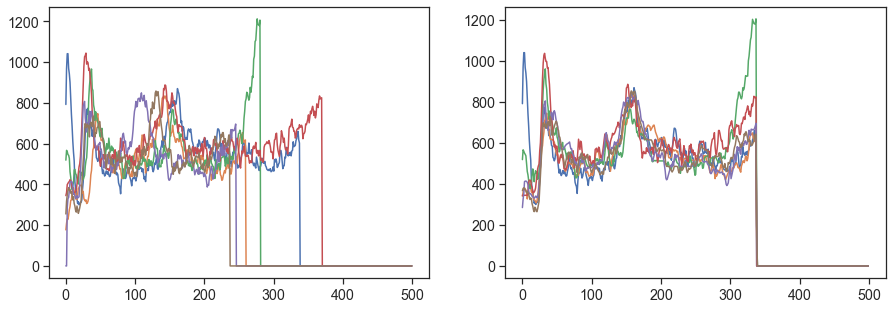

In [7]:
# standard alignment
std_00 = tracks_original['track_00'].Standard.isel(track=0).data
std_01 = tracks_original['track_01'].Standard.isel(track=0).data
std_02 = tracks_original['track_02'].Standard.isel(track=0).data
std_03 = tracks_original['track_03'].Standard.isel(track=0).data
std_v1 = tracks_original['track_v1'].Standard.isel(track=0).data
std_v2 = tracks_original['track_v2'].Standard.isel(track=0).data

std_00_02, arg00_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_00)
std_01_02, arg01_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_01)
arg02_02 = np.arange(std_02.size)
std_03_02, arg03_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_03)
std_v1_02, argv1_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_v1)
std_v2_02, argv2_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_v2)

standard_shifts = {
    'track_00':arg00_02,
    'track_01':arg01_02,
    'track_02':arg02_02,
    'track_03':arg03_02,
    'track_v1':argv1_02,
    'track_v2':argv2_02,
}

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

axs[0].plot(std_02)
axs[0].plot(std_00)
axs[0].plot(std_01)
axs[0].plot(std_03)
axs[0].plot(std_v1)
axs[0].plot(std_v2)

axs[1].plot(std_02)
axs[1].plot(std_00_02)
axs[1].plot(std_01_02)
axs[1].plot(std_03_02)
axs[1].plot(std_v1_02)
axs[1].plot(std_v2_02)

## Convert to counts per kernel volume

In [8]:
def count_warp(track, counts, disp):
    warp_arg = morphotrack.align.composite_displacement(
        track.Total_arg.sel(displacement='t2s'),
        np.repeat(disp[:,np.newaxis], track.track.size, axis=1).T
    )

    transformed = track.Kernel_counts.copy()
    transformed[:] = morphotrack.align.positional_mapping(counts, warp_arg)
    
    return transformed

In [9]:
tissue_sets = {}
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer
cell_set = ['nuclei','plp1','slc17a7']

for g in cell_set:
    arrs = []
    for tr in ['track_00','track_01','track_02','track_03','track_v1','track_v2']:
        if g in cell_coords[tr].keys():        
            if g == 'nuclei':
                kc_xr = tracks[tr].Kernel_counts.copy()
            else:
                kc = morphotrack.points.count_around_position_in_disk_kernel(tracks[tr].Position, cell_coords[tr][g], half_thickness, radius)
                kc = kc.fillna(0)

                # fix coordinate
                kc_xr = tracks[tr].Kernel_counts.copy()
                kc_xr[:] = 0
                kc_xr = kc_xr + kc

            warped_kc = count_warp(tracks[tr], kc_xr, standard_shifts[tr])
            warped_kc = warped_kc.assign_coords({'track_set': ('track',np.full(warped_kc.track.size,tr))})
            arrs.append(warped_kc)
    # 
    tissue_sets[g] = xr.concat(arrs,dim='track')

In [10]:
### Here is how I index by non dimensional coordinate

ex_ratio0 = (tissue_sets['slc17a7'] / tissue_sets['nuclei'])
ex_ratio0 = ex_ratio0.where(ex_ratio0.data!=np.inf,np.nan)

ex_ratio1 = (tissue_sets['plp1'] / tissue_sets['nuclei'])
ex_ratio1 = ex_ratio1.where(ex_ratio1.data!=np.inf,np.nan)

ex_ratio2 = (tissue_sets['plp1'] / tissue_sets['slc17a7'])
ex_ratio2 = ex_ratio2.where(ex_ratio2.data!=np.inf,np.nan)

viewer = napari.Viewer()
# viewer.add_image(ex_ratio0.data, contrast_limits=[0,1], name='excitatory_ratio', colormap='turbo', blending='additive',visible=False)
# viewer.add_image(ex_ratio1.data, contrast_limits=[0,1], name='oligo_ratio', colormap='turbo', blending='additive',visible=False)
# viewer.add_image(ex_ratio2.data, contrast_limits=[0,1], name='oligo_per_exc', colormap='turbo', blending='additive',visible=False)

viewer.add_image(tissue_sets['nuclei'].data, name='nuclei', colormap='turbo', blending='additive')
# viewer.add_image(tissue_sets['slc17a7'].data, name='slc17a7', colormap='turbo', blending='additive',visible=False)
# viewer.add_image(tissue_sets['plp1'].data, name='plp1', colormap='turbo', blending='additive',visible=False)

viewer.add_image(zscore(ex_ratio0.fillna(0).data,axis=0), contrast_limits=[-1,1], name='excitatory_ratio', colormap='turbo', blending='additive',visible=False)
viewer.add_image(zscore(ex_ratio1.fillna(0).data,axis=0), contrast_limits=[-1,1], name='oligo_ratio', colormap='turbo', blending='additive',visible=False)
viewer.add_image(zscore(ex_ratio2.fillna(0).data,axis=0), contrast_limits=[-1,1], name='oligo_per_exc', colormap='turbo', blending='additive',visible=False)

viewer.add_image(zscore(tissue_sets['nuclei'].data,axis=0), contrast_limits=[-1,1], name='nuclei', colormap='turbo', blending='additive')
viewer.add_image(zscore(tissue_sets['slc17a7'].data,axis=0), contrast_limits=[-1,1], name='slc17a7', colormap='turbo', blending='additive',visible=False)
viewer.add_image(zscore(tissue_sets['plp1'].data,axis=0), contrast_limits=[-1,1], name='plp1', colormap='turbo', blending='additive',visible=False)
viewer.add_image(zscore(tissue_sets['plp1'].data[:,0:200],axis=1), name='plp1', colormap='gray', blending='additive',visible=False)


<Image layer 'plp1 [1]' at 0x7f544bbd2880>

## Calculate flux in layers

In [11]:
# combine everything for the analysis
combined_local_flux = []
stack_local_flux = []
combined_flux = []
layer_reference_time = 320
local_flux_reference_time = 180

stack_local_thickness = []
window = 10

for tr in tracks:
    # get flux and local flux
    t = round(standard_shifts[tr][layer_reference_time])
    lf = tracks[tr].Local_flux.copy()
    warped_lf = count_warp(tracks[tr], lf.T, standard_shifts[tr])
    warped_lf = warped_lf.assign_coords({'track_set': ('track',np.full(warped_lf.track.size,tr))})
    stack_local_flux.append(warped_lf)

    dist = morphotrack.distance.position2distance_xr(tracks[tr].Warped_position)

    flux = ((dist*lf).fillna(0)).sel(warped_time=slice(0, t)).sum(dim='warped_time')
    combined_flux.append(flux)
    
    tf = round(standard_shifts[tr][local_flux_reference_time])
    combined_local_flux.append(lf.sel(warped_time=tf).data)
    # the following is to calculate local thickness 
    layer_position = []
    final_warp_arg_np = morphotrack.align.composite_displacement(
        tracks[tr].Total_arg.sel(displacement='t2s'),
        np.repeat(standard_shifts[tr][:,np.newaxis], tracks[tr].track.size, axis=1).T
    )
    final_arg = tracks[tr].Total_arg.copy()
    final_arg[:] = final_warp_arg_np

    for t in tracks[tr].track.data:
        interp_position = tracks[tr].Position.sel(track=t).interp(time=final_arg.sel(displacement='t2s',track=t).data)
        interp_position = interp_position.assign_coords(time=np.arange(tracks[tr].time[0],tracks[tr].time[-1]+1))
        layer_position.append(interp_position)
    layer_position = xr.concat(layer_position,dim='track')
    thickness = morphotrack.distance.position2distance_xr(layer_position)
    thickness = thickness.rolling(time=window, center=True).mean()
    thickness = thickness.assign_coords({'track_set': ('track',np.full(thickness.track.size,tr))})
    stack_local_thickness.append(thickness)

combined_local_flux = np.hstack(combined_local_flux)
combined_local_flux = xr.DataArray(combined_local_flux,coords=tissue_sets['nuclei'].track.coords)

stack_local_flux = xr.concat(stack_local_flux,dim='track')

combined_flux = np.hstack(combined_flux)
combined_flux = xr.DataArray(combined_flux,coords=tissue_sets['nuclei'].track.coords)

stack_local_thickness = xr.concat(stack_local_thickness,dim='track')

In [12]:
viewer = napari.Viewer()
viewer.add_image(stack_local_thickness)
viewer.add_image(tissue_sets['nuclei'].data, name='nuclei', colormap='turbo', blending='additive')

<Image layer 'nuclei' at 0x7f544b8bea60>

[0.23782971 0.12101969 0.09087194 0.07177059 0.04128628 0.03009786
 0.02117413 0.01916706 0.01697615 0.01322996]
0.6634233643301307


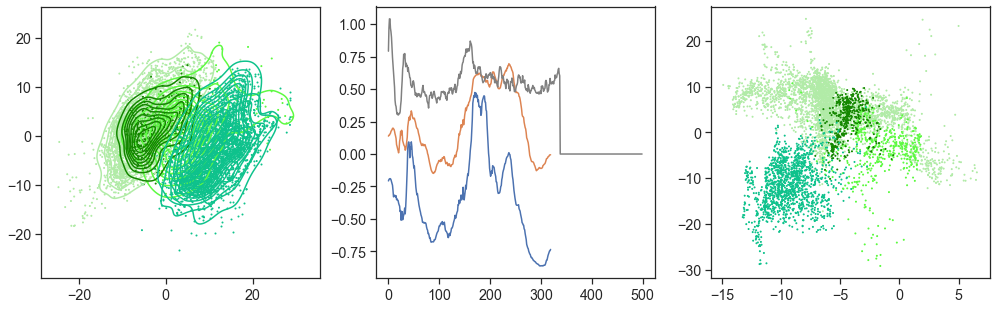

In [13]:
# trim the white matter to exclude the influence of the white matter.
g = 'nuclei'
selections = ['track_00','track_01','track_02','track_03'] #
test_selection = 'track_03'

trim_start = 0
trim_end = 320

ds = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].data # ex_ratio1.fillna(0).data #
dat = ds
scaler = StandardScaler()
scaler.fit(dat)
combined_tracks_zscore = scaler.transform(dat)

pca = PCA().fit(combined_tracks_zscore[:,trim_start:trim_end])
pcs = pca.transform(combined_tracks_zscore[:,trim_start:trim_end])
pc1 = pcs[:,0]
pc2 = pcs[:,1]
pc3 = pcs[:,2]

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

colors = np.full(pc1.shape,'#b1eba7')
count = 0
for tr in selections:
    i = (tissue_sets['nuclei'].track_set==tr).sum().data
    colors[count:count+i] = color_dict[tr]
    count = count+i
    
fig, axs = plt.subplots(ncols=3, figsize=(17,5))

count = 0
for tr in selections:
    i = (tissue_sets['nuclei'].track_set==tr).sum().data
    # idx = tissue_sets[g].track[tissue_sets[g].track_set==tr].data
    axs[0].scatter(pc1[count:count+i],pc2[count:count+i],s=1,c=colors[count:count+i])
    sns.kdeplot(x=pc1[count:count+i],y=pc2[count:count+i],color=color_dict[tr],ax=axs[0])
    count = count+i

# check with test data sets 
test_zscore = scaler.transform(tissue_sets[g][tissue_sets[g].track_set.isin([test_selection])].data)
test_pcs = pca.transform(test_zscore[:,trim_start:trim_end])
axs[0].scatter(test_pcs[:,0],test_pcs[:,2],s=1,c=color_dict[test_selection])
sns.kdeplot(x=test_pcs[:,0],y=test_pcs[:,2],color=color_dict[test_selection],ax=axs[0])

axs[1].plot(-loadings[:,0])
axs[1].plot(loadings[:,1]) 
axs[1].plot(std_02[trim_start:]/1000,c='gray')

axs[2].scatter(combined_flux[tissue_sets['nuclei'].track_set.isin(selections)], -pc1 ,s=1, c=colors)

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())

(-0.3695385386218227, 2.64860682540057e-177) (0.37347749203016267, 2.348061726955137e-181) (0.14305265639960435, 1.674399825292704e-26)


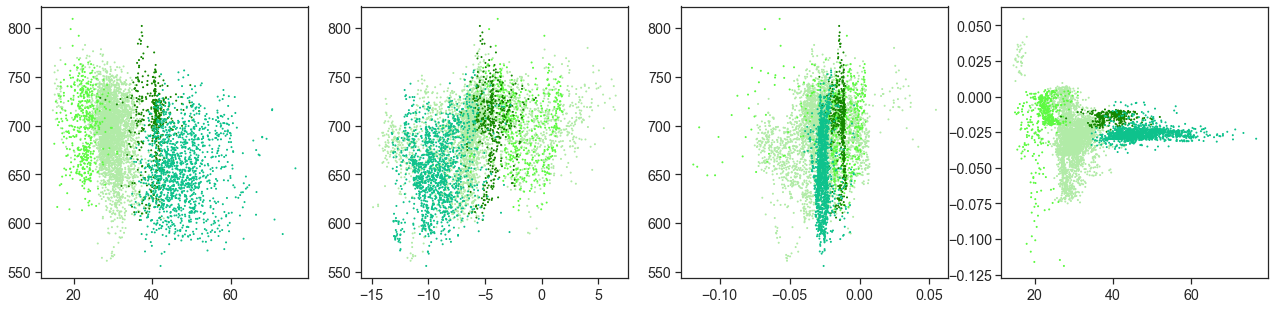

In [14]:
# instead of PC1, use a layer.
# l_pos = np.asarray([0,25,55,140,180,300,320])
fig, axs = plt.subplots(ncols=4, figsize=(22,5))
l_start = 140; l_end = 180
l = stack_local_thickness.fillna(0).sel(time=slice(l_start,l_end)).sum(dim='time')[tissue_sets['nuclei'].track_set.isin(selections)]
f = combined_flux[tissue_sets['nuclei'].track_set.isin(selections)]
fl = combined_local_flux[tissue_sets['nuclei'].track_set.isin(selections)]

ds = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].data
m = ds[:,l_start:l_end].mean(axis=1)

axs[0].scatter(l, m ,s=1, c=colors)
axs[1].scatter(f, m ,s=1, c=colors)
axs[2].scatter(fl, m ,s=1, c=colors)
axs[3].scatter(l, fl, s=1, c=colors)
print(pearsonr(l, m),pearsonr(f, m), pearsonr(fl, m))


(0.0, 900.0)

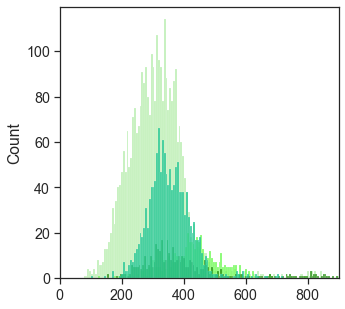

In [15]:
g = 'nuclei'
selections = ['track_00','track_01','track_02','track_03']
fig, axs = plt.subplots(ncols=1, figsize=(5,5))
for tr in selections:
    ds = tissue_sets[g][tissue_sets[g].track_set.isin(tr)].data
    sns.histplot(ds[:,0],binwidth=6,color=color_dict[tr])
axs.set_xlim(0,900)

(0.7205793257021645, 0.0)


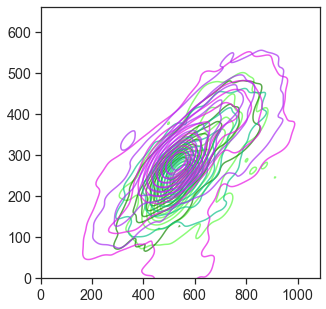

In [16]:
fig, axs = plt.subplots(ncols=1, figsize=(5,5))
selections = ['track_01','track_02','track_03','track_v1','track_v2']
ga = 'nuclei'
gb = 'slc17a7'
trim_start = 25
trim_end = 300
a_ = []
b_ = []
for tr in selections:
    a = tissue_sets[ga][tissue_sets[ga].track_set.isin(tr)].data[:,trim_start:trim_end].flatten()
    b = tissue_sets[gb][tissue_sets[gb].track_set.isin(tr)].data[:,trim_start:trim_end].flatten() 
    sns.kdeplot(x=a[::100],y=b[::100], color=color_dict[tr], fill=False, alpha=0.7, thresh=0.01)
    a_.append(a); b_.append(b)
    #
plt.xlim(0)
plt.ylim(0)
print(pearsonr(np.hstack(a_),np.hstack(b_)))

# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/nuclei_plp1_kde.svg')

In [1141]:
#

## make PLS model with nuclei and apply it for others

In [17]:
# how each positions of line are affected by local flux. test this with PLS.
# also read this. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html

def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [16]:
# # make a model
# selections = ['track_v1','track_v2']
# # ds = xr.concat([tissue_sets['plp1'],tissue_sets['slc17a7'],tissue_sets['nuclei'][tissue_sets['nuclei'].track_set.isin(selections)]],dim='time')#
# ds = tissue_sets['plp1']
# flux_of_choice = combined_flux

# # data selection for pls
# trim_start = 0
# trim_end = -1 # 320
# combined_tracks_zscore = zscore(ds.data, axis=0)
# selected_tracks_zscore = combined_tracks_zscore[ds.track_set.isin(selections),:]
# selected_flux = flux_of_choice[flux_of_choice.track_set.isin(selections)]

# vals = selected_tracks_zscore[:,trim_start:trim_end]
# vals[np.isnan(vals)] = 0
# kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
# mse = []

# for i in np.arange(1, 20):
#     pls = PLSRegression(n_components=i)
#     score = model_selection.cross_val_score(pls, vals, selected_flux, cv=kf_10, scoring='neg_mean_squared_error').mean()
#     mse.append(-score)
# pls = PLSRegression(n_components=np.argmin(mse)).fit(vals, selected_flux)
# print(np.argmin(mse))

7


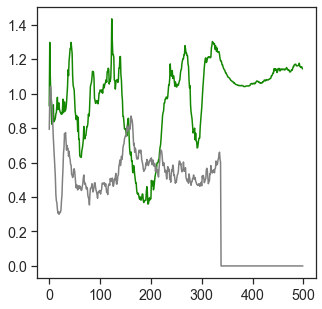

In [17]:
# fig, axs = plt.subplots(ncols=1, figsize=(5,5))

# axs.plot(vip(vals,selected_flux,pls),c='#148700')
# axs.plot(std_02[trim_start:]/1000,c='gray')
# # axs.plot(np.tile(std_02[trim_start:],3)/1000,c='gray')

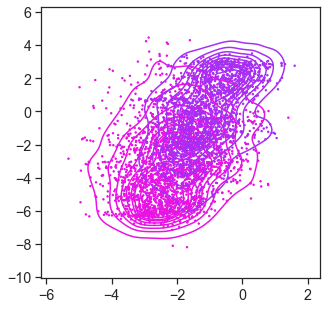

In [18]:
# # apply the model to other
# ds = (tissue_sets['plp1'] / tissue_sets['slc17a7'])#tissue_sets['slc17a7']
# selections = ['track_v1','track_v2']

# # data selection for pls
# combined_tracks_zscore = zscore(ds.data, axis=0)
# selected_tracks_zscore = combined_tracks_zscore[ds.track_set.isin(selections),:]
# selected_flux = flux_of_choice[flux_of_choice.track_set.isin(selections)]
# vals = selected_tracks_zscore[:,trim_start:trim_end]
# vals[np.isnan(vals)] = 0

# colors = np.full(selected_flux.shape,'#b1eba7')
# count = 0
# for tr in selections:
#     # idx = tissue_sets['nuclei'].track[tissue_sets['nuclei'].track_set==tr].data
#     i = (tissue_sets['nuclei'].track_set==tr).sum().data
#     colors[count:count+i] = color_dict[tr]
#     count = count+i

# fig, axs = plt.subplots(ncols=1, figsize=(5,5))
# plt.scatter(pls.predict(vals).flatten(),selected_flux,s=2,c=colors)

# count = 0
# for tr in selections:
#     i = (tissue_sets['nuclei'].track_set==tr).sum().data
#     sns.kdeplot(x=pls.predict(vals).flatten()[count:count+i],y=selected_flux[count:count+i],color=color_dict[tr])
#     count = count+i

## Relation of thickness and density

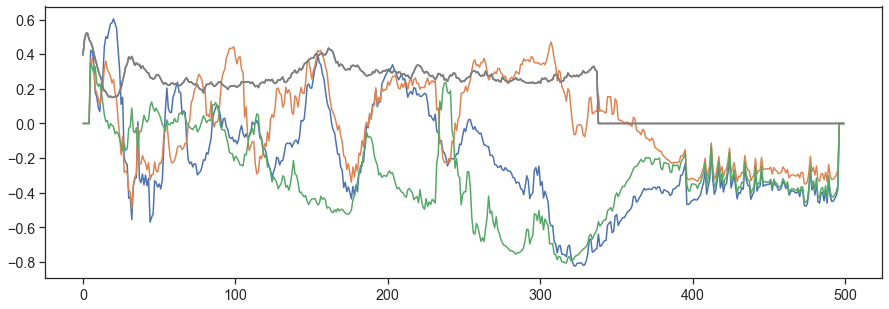

In [19]:
# selections = ['track_01','track_02']
# r_list = np.zeros(500)
# gs = ['nuclei','slc17a7','plp1']

# fig, axs = plt.subplots(ncols=1, figsize=(15,5))

# for g in gs:
#     for i, reference_time in enumerate(range(0,500)):
#         a = stack_local_thickness[stack_local_thickness.track_set.isin(selections)].sel(time=reference_time)
#         b = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=reference_time)
#         p = np.isnan(a)|np.isnan(b)
#         if (~p).sum() > 2:
#             r,_ = pearsonr(a[~p],b[~p])
#             r_list[i] = r
#     plt.plot(r_list)
#     plt.plot(std_02[trim_start:]/2000,c='gray')

Relation of local flux and thickness

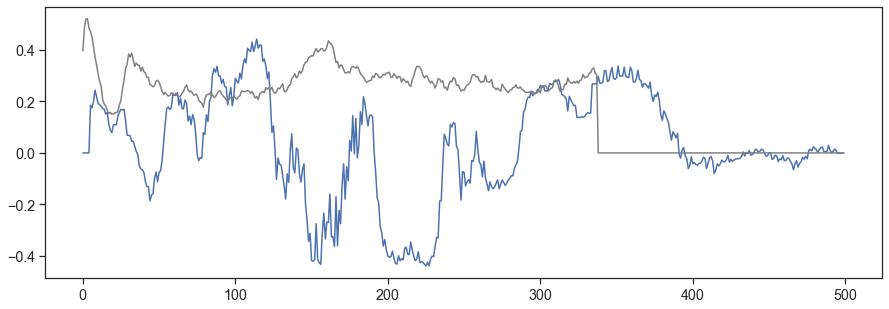

In [20]:
# selections = ['track_00','track_01','track_02']
# r_list = np.zeros(500)

# fig, axs = plt.subplots(ncols=1, figsize=(15,5))

# for i, reference_time in enumerate(range(0,500)):
#     a = stack_local_thickness[stack_local_thickness.track_set.isin(selections)].sel(time=reference_time)
#     b = stack_local_flux[stack_local_flux.track_set.isin(selections)].sel(time=reference_time)
#     p = np.isnan(a)|np.isnan(b)
#     if (~p).sum() > 2:
#         r,_ = pearsonr(a[~p],b[~p])
#         r_list[i] = r
# plt.plot(r_list)
# plt.plot(std_02[trim_start:]/2000,c='gray')

## Regression model for prefrontal and visual

In [32]:
# define Cohen's d
# https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def cohen_d_2d(x,y):
    nx = x.shape[0]
    ny = y.shape[0]
    dof = nx + ny - 2
    return (np.mean(x,axis=0) - np.mean(y,axis=0)) / np.sqrt(((nx-1)*np.std(x, ddof=1,axis=0) ** 2 + (ny-1)*np.std(y, ddof=1,axis=0) ** 2) / dof)

# https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
# multiple linear regression test for the significant differences in thickness between two regions
# https://stats.stackexchange.com/questions/71816/calculating-effect-size-for-variables-in-a-multiple-regression-in-r

def cohen_f2_from_R2(R2_ctrl, R2_all):
    return (R2_all-R2_ctrl) / (1-R2_all)

def cohen_f2(x_interest,x_control,y):
    """
    Args
        x_interest (1darray):
        x_control (ndarray):
        y (1darray): 
    Return
        cohen's f squared
    reference: https://www.frontiersin.org/articles/10.3389/fpsyg.2012.00111/full
    """
    if x_control.ndim == 1:
        # get R**2 of variables for controls
        X_control = x_control.reshape(-1,1)
        reg_control = LinearRegression().fit(X_control, y)
        R2_control = reg_control.score(X_control, y)
        
        # get R**2 of all variables
        X = np.vstack([x1,x2]).T
        reg = LinearRegression().fit(X, y)
        R2 = reg.score(X,y)
        
        return cohen_f2_from_R2(R2_control, R2)
    elif x_control.ndim == 2:
        # get R**2 of variables for controls
        X_control = x_control
        reg_control = LinearRegression().fit(X_control, y)
        R2_control = reg_control.score(X_control, y)
        
        # get R**2 of all variables
        X = np.hstack([x_interest.reshape(-1,1),x_control])
        reg = LinearRegression().fit(X, y)
        R2 = reg.score(X,y)
        
        return cohen_f2_from_R2(R2_control, R2)
    else:
        print('wrong input')

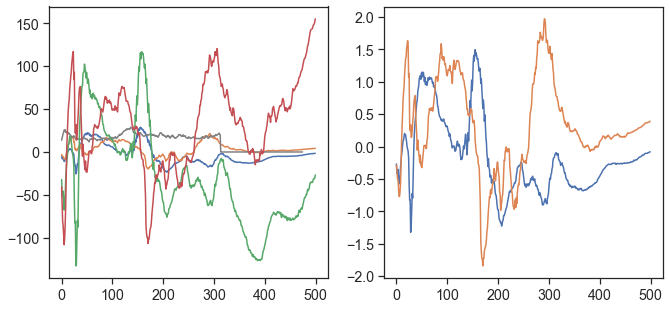

In [19]:
from scipy.stats import ttest_ind, kruskal
# control the flux and visualize
sel = (combined_flux>=-7.) & (combined_flux<=-3.)

ds = tissue_sets['nuclei']

a = ds.data[ds.track_set.isin(['track_01','track_02'])&sel,:]
b = ds.data[ds.track_set.isin(['track_v1','track_v2'])&sel,:]
c = ds.data[ds.track_set.isin(['track_03'])&sel,:]

fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].plot(ttest_ind(b,a).statistic)
axs[0].plot(ttest_ind(c,a).statistic)

# axs.plot(b.mean(axis=0)-a.mean(axis=0))
axs[0].plot(std_02[trim_start:]/30,c='gray')
axs[0].plot(b.mean(axis=0) - a.mean(axis=0))
axs[0].plot(c.mean(axis=0) - a.mean(axis=0))

axs[1].plot(cohen_d_2d(b,a))
axs[1].plot(cohen_d_2d(c,a))
#axs.set_ylim([-50,50]
# I expect layer 4 is more dense in BA18/19 compared to prefrontal cortex

pls-da is better than multiple t test in my case

17


(0.0, 2.0)

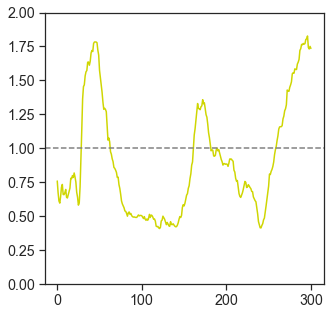

In [20]:
# make a model
selections = ['track_01','track_02','track_03','track_v1','track_v2'] # 
trim_start = 0
trim_end = 300 # 320
# sel = (combined_flux>=-2.) & (combined_flux<=2.)
g = 'plp1'
ds = xr.concat([
    tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)),
    # tissue_sets['nuclei'][tissue_sets['nuclei'].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)),
    # tissue_sets['slc17a7'][tissue_sets['slc17a7'].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)),
    # tissue_sets['plp1'][tissue_sets['plp1'].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)),
    # stack_local_thickness[stack_local_thickness.track_set.isin(selections)].sel(time=slice(trim_start,trim_end)),
    # combined_flux[combined_flux.track_set.isin(selections)].assign_coords(time=0).expand_dims(dim='time'),
    ]
    ,dim='time')#

cla = ds.track_set.isin(['track_v1','track_v2']).astype(int).data
# cla = combined_flux[combined_flux.track_set.isin(selections)].data
# cla = stack_local_flux[stack_local_flux.track_set.isin(selections)].sel(time=200).data
# cla = combined_local_flux[combined_local_flux.track_set.isin(selections)].data

# data selection for pls
scaler = StandardScaler().fit(ds.data)
vals = scaler.transform(ds.data)
vals[np.isnan(vals)] = 0

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, vals, cla, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
pls = PLSRegression(n_components=np.argmin(mse)).fit(vals, cla)
print(np.argmin(mse))

fig, axs = plt.subplots(ncols=1, figsize=(5,5))

gene_color = {'nuclei':'#d6d6d6','slc17a7':'#0ec220','plp1':'#cfd602'}
axs.plot(vip(vals,cla,pls),c=gene_color[g])
# axs.plot(np.tile(std_02[trim_start:trim_end],4)/1000,c='gray')
axs.axhline(1.0, linestyle='--',color='gray')
axs.set_ylim(0,2.0)
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/' + g + '_pls_vip.svg')

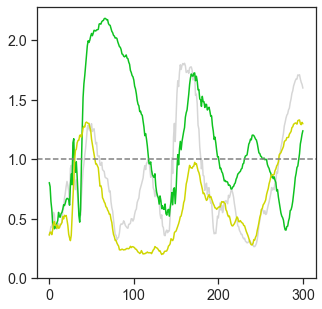

In [1631]:
# fig, axs = plt.subplots(ncols=1, figsize=(5,5))
# gene_color = {'nuclei':'#d6d6d6','slc17a7':'#0ec220','plp1':'#cfd602'}

# for i, g in enumerate(gene_color):
#     score = vip(vals,cla,pls)[i*301:(i+1)*301]
#     axs.plot(score,c=gene_color[g])
# axs.axhline(1.0, linestyle='--',color='gray')
# axs.set_ylim(0)
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/all_pls_vip.svg')

0.6912193476719068
0.6984275834037459
0.8933122050715994


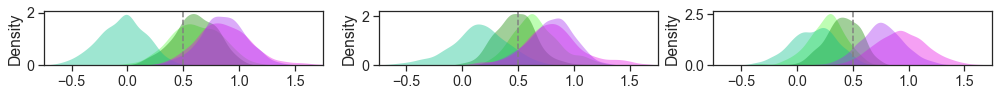

In [22]:
# apply the model to other
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17,1))
cells = ['nuclei','slc17a7','plp1']
selections = ['track_01','track_02','track_03','track_v1','track_v2']
boundary = 0.5

for i, g in enumerate(cells):
    ds = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=slice(trim_start,trim_end))
    scaler = StandardScaler().fit(ds.data)
    vals = scaler.transform(ds.data)
    f1s = []
    for tr in np.asarray(selections):
        sns.kdeplot(pls.predict(vals).flatten()[ds.track_set.isin(tr)], color=color_dict[tr], ax=axs[i], fill=True, alpha=0.4, linewidth=0)
        f1 = accuracy_score(cla[ds.track_set.isin(tr)],(pls.predict(vals).flatten()[ds.track_set.isin(tr)]>boundary).astype(int))
        f1s.append(f1)
    # pred = pls.predict(vals).flatten()>boundary
    print(np.asarray(f1s).mean())
    axs[i].set_xlim([-0.75,1.75])# ; axs[1,i].set_xlim([-0.75,1.75]) 
    axs[i].axvline(0.5, linestyle='--',color='gray')# ; axs[1,i].axvline(0.5, linestyle='--',color='gray')
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/plp1_pls_prediction.svg')
# accuracy_score

In [1682]:
# # apply the model to other
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(17,2))

# selections = ['track_01','track_02','track_03','track_v1','track_v2']
# test = 'track_03'

# for i, g in enumerate(cells):
#     ds = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=slice(trim_start,trim_end))
#     scaler = StandardScaler().fit(ds[~ds.track_set.isin(test)].data)
#     vals = scaler.transform(ds.data)
#     for tr in np.asarray(selections)[~np.isin(selections,test)]:
#         sns.kdeplot(pls.predict(vals).flatten()[ds.track_set.isin(tr)], color=color_dict[tr], ax=axs[0,i], fill=True, alpha=0.4, linewidth=0)
#     test_val = pls.predict(vals).flatten()[ds.track_set.isin(test)]
#     sns.kdeplot(test_val, color=color_dict[test],  ax=axs[1,i], fill=True, alpha=0.4, linewidth=0)
#     axs[0,i].set_xlim([-0.75,1.75]); axs[1,i].set_xlim([-0.75,1.75]) 
#     axs[0,i].axvline(0.5, linestyle='--',color='gray'); axs[1,i].axvline(0.5, linestyle='--',color='gray')
#     print((test_val<0.5).sum() / test_val.size)

### Correlation analysis of Plp1 and Slc17a7

In [23]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def create_shift_arr(x, window, start=0, end=None):
    shifted_x = []
    if end is None:
        for i in range(-window[0], -window[1], -1):
            shifted_x.append(np.roll(x,i)[start:])
    else:
        for i in range(-window[0], -window[1], -1):
            shifted_x.append(np.roll(x,i)[start:end])
    shifted_x = np.asarray(shifted_x).T
    return shifted_x

In [1277]:
# from sklearn.feature_selection import mutual_info_regression

# selections = ['track_01','track_02','track_03','track_v1','track_v2']
# trim_start = 50
# trim_end = 200

# ds_n = tissue_sets['nuclei'][tissue_sets['nuclei'].track_set.isin(selections)].sel(time=slice(trim_start,trim_end))
# ds_s = tissue_sets['slc17a7'][tissue_sets['slc17a7'].track_set.isin(selections)].sel(time=slice(trim_start,trim_end))
# ds_p = tissue_sets['plp1'][tissue_sets['plp1'].track_set.isin(selections)].sel(time=slice(trim_start,trim_end))

# # for t in ds_n.track.data:
# sn_f = []; sn_r = []; sp_f = []; sp_r = []
# bins = 10
# for t in tqdm(ds_s.track.data):
#     sn_f.append(mutual_info_regression(ds_s.sel(track=t).data.reshape(-1,1), ds_n.sel(track=t).data, random_state=42))
#     sn_r.append(mutual_info_regression(ds_s.sel(track=t).data.reshape(-1,1), ds_n.sel(track=t).data[::-1], random_state=42))
#     sp_f.append(mutual_info_regression(ds_s.sel(track=t).data.reshape(-1,1), ds_p.sel(track=t).data, random_state=42))
#     sp_r.append(mutual_info_regression(ds_s.sel(track=t).data.reshape(-1,1), ds_p.sel(track=t).data[::-1], random_state=42))
#     # sn_f.append(calc_MI(ds_s.sel(track=t).data, ds_n.sel(track=t).data, bins))
#     # sn_r.append(calc_MI(ds_s.sel(track=t).data, ds_n.sel(track=t).data[::-1], bins))
#     # sp_f.append(calc_MI(ds_s.sel(track=t).data, ds_p.sel(track=t).data, bins))
#     # sp_r.append(calc_MI(ds_s.sel(track=t).data, ds_p.sel(track=t).data[::-1], bins))

# sn_f = np.asarray(sn_f).squeeze(); sn_r = np.asarray(sn_r).squeeze()
# sp_f = np.asarray(sp_f).squeeze(); sp_r = np.asarray(sp_r).squeeze()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5904/5904 [00:37<00:00, 159.41it/s]


In [24]:
def mi_from_xr(xr_target, xr_template, trim_start, trim_end, window, t, random_state=42):
    target = xr_target.sel(time=slice(trim_start,trim_end),track=t).data
    template = create_shift_arr(xr_template.sel(track=t).data, window, trim_start, trim_end+1)
    
    return mutual_info_regression(template, target, random_state=random_state)

In [25]:
import ray
@ray.remote
def ray_mi_2(t, xr_target, xr_template, trim_start, trim_end, window):
    target = xr_target.sel(time=slice(trim_start,trim_end),track=t).data
    template = create_shift_arr(xr_template.sel(track=t).data, window, trim_start, trim_end+1)

    return mutual_info_regression(template, target, random_state=42)

In [1683]:
selections = ['track_01','track_02','track_03','track_v1','track_v2']
trim_start = 50
trim_end = 200
window = (-50,100)

ds_s = tissue_sets['slc17a7'][tissue_sets['slc17a7'].track_set.isin(selections)]
ds_n = tissue_sets['nuclei'][tissue_sets['nuclei'].track_set.isin(selections)]
ds_nr = ds_n.copy(); ds_nr[:] = np.flip(ds_n.data,axis=1)
ds_p = tissue_sets['plp1'][tissue_sets['plp1'].track_set.isin(selections)]
ds_pr = ds_p.copy(); ds_pr[:] = np.flip(ds_p.data,axis=1)

ds_s_id = ray.put(ds_s); ds_n_id = ray.put(ds_n); ds_p_id = ray.put(ds_p)
ds_nr_id = ray.put(ds_nr); ds_pr_id = ray.put(ds_pr)

mi_sp_f = []; mi_sp_r = []; mi_sn_f = []; mi_sn_r = [];  mi_np_f = []
# for t in tqdm(ds_s.track.data):
#     mi_sp_f.append(mi_from_xr(ds_p, ds_s, trim_start, trim_end, window, t))
#     mi_sp_r.append(mi_from_xr(ds_pr, ds_s, trim_start, trim_end, window, t))
#     mi_sn_f.append(mi_from_xr(ds_n, ds_s, trim_start, trim_end, window, t))

# mi_sp_f = np.asarray(mi_sp_f)
# mi_sp_r = np.asarray(mi_sp_r)
# mi_sn_f = np.asarray(mi_sn_f)
for t in ds_s.track.data:
    mi_sp_f.append(ray_mi_2.remote(t, ds_p_id, ds_s_id, trim_start, trim_end, window))
    mi_sp_r.append(ray_mi_2.remote(t, ds_pr_id, ds_s_id, trim_start, trim_end, window))
    mi_sn_f.append(ray_mi_2.remote(t, ds_n_id, ds_s_id, trim_start, trim_end, window))
    mi_sn_r.append(ray_mi_2.remote(t, ds_nr_id, ds_s_id, trim_start, trim_end, window))
    mi_np_f.append(ray_mi_2.remote(t, ds_p_id, ds_n_id, trim_start, trim_end, window))

mi_sp_f = np.asarray(ray.get(mi_sp_f))
mi_sp_r = np.asarray(ray.get(mi_sp_r))
mi_sn_f = np.asarray(ray.get(mi_sn_f))
mi_sn_r = np.asarray(ray.get(mi_sn_r))
mi_np_f = np.asarray(ray.get(mi_np_f))

(ray_mi_2 pid=1102492) 


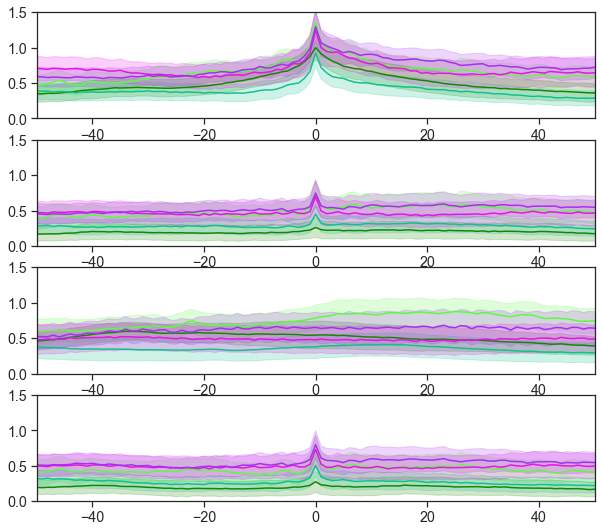

In [1684]:
fig, axs = plt.subplots(nrows=4, figsize=(10,9))

for i, mi in enumerate([mi_sn_f, mi_sp_f, mi_sp_r, mi_np_f]):
    for tr in ['track_01','track_02','track_03','track_v1','track_v2']:
        sel = ds_s.track_set.isin(tr)
        mean = mi[sel,:].mean(axis=0)
        std = mi[sel,:].std(axis=0)

        x = np.arange(len(mean))+window[0]
        axs[i].plot(x, mean, color_dict[tr], label=tr)
        axs[i].fill_between(x, mean - std, mean + std, color=color_dict[tr], alpha=0.2)
        axs[i].set_ylim([0,1.5]); axs[i].set_xlim([-50,50])

In [1603]:
# fig, axs = plt.subplots(figsize=(5,5))
# sns.kdeplot(x=mi_sn_r[:,-window[0]], y=mi_sn_f[:,-window[0]], color='#a2c1e0')
# sns.kdeplot(x=mi_sn_r[:,-window[0]], y=mi_sp_r[:,-window[0]], color='#c3c6c9')
# sns.kdeplot(x=mi_sp_r[:,-window[0]], y=mi_sp_f[:,-window[0]], color='#b58941')
# m = 2
# axs.set_xlim([0,m]); axs.set_ylim([0,m])
# axs.plot([0, m], [0, m], ls="--", c=".3")

# print((mi_sn_f[:,-window[0]]>mi_sn_r[:,-window[0]]).sum() / mi_sn_f[:,-window[0]].size)
# print((mi_sp_r[:,-window[0]]>mi_sn_r[:,-window[0]]).sum() / mi_sp_r[:,-window[0]].size)
# print((mi_sp_f[:,-window[0]]>mi_sp_r[:,-window[0]]).sum() / mi_sp_f[:,-window[0]].size)
mis = (mi_sn_f, mi_sn_r)
mi_list = []
for mis in [(mi_sn_f, mi_sn_r),(mi_sp_r, mi_sn_r),(mi_sp_f, mi_sp_r)]:
    mi_ratio = {}
    for tr in ['track_01','track_02','track_03','track_v1','track_v2']:
        sel = ds_s.track_set.isin(tr)
        mi_a = mis[0]; mi_b = mis[1]
        mi_a = mi_a[:,-window[0]][sel]; mi_b = mi_b[:,-window[0]][sel]
        mi_ratio[tr] = ((mi_a>mi_b).sum()/mi_a.size)
    mi_list.append(mi_ratio)
pd.DataFrame(mi_list)

,track_01,track_02,track_03,track_v1,track_v2
0,0.981250,0.917051,0.991150,0.994455,0.983673
1,0.370833,0.225806,0.501475,0.407116,0.648980
2,0.445833,0.103687,0.651917,0.807763,0.643537


### Simple density visualization

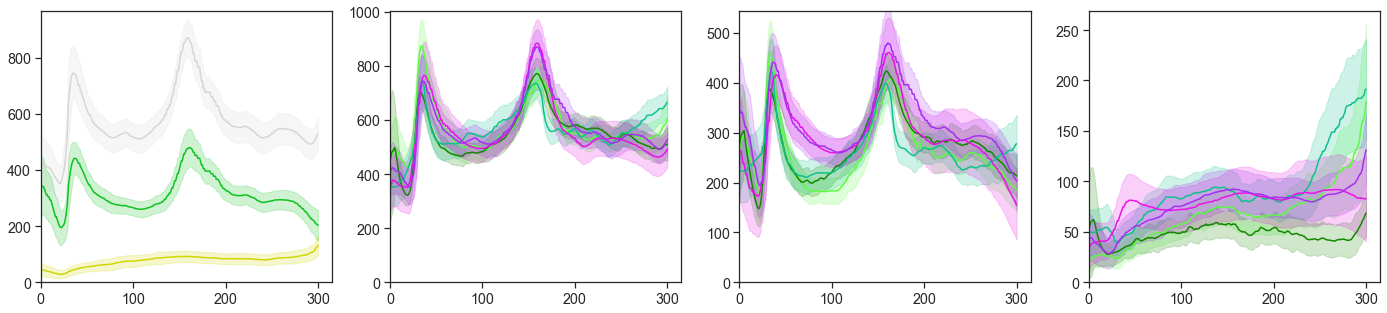

In [26]:
# visualization of laminar patterns
tr = 'track_v2'
trim_start = 0
trim_end = 300

selections = ['track_01','track_02','track_03','track_v1','track_v2']
gene_color = {'nuclei':'#d6d6d6','slc17a7':'#0ec220','plp1':'#cfd602'}
fig, axs = plt.subplots(ncols=4, figsize=(24, 5))
for g in ['nuclei','slc17a7','plp1']:
    ds = tissue_sets[g][tissue_sets[g].track_set.isin(tr)].sel(time=slice(trim_start,trim_end))
    mean = ds.mean(dim='track').data
    std = ds.std(dim='track') .data

    x = np.arange(len(mean))
    axs[0].plot(x, mean, gene_color[g], label=tr)
    axs[0].fill_between(x, mean - std, mean + std, color=gene_color[g], alpha=0.2)
    axs[0].set_xlim(0); axs[0].set_ylim(0)

g = 'nuclei'
for tr in selections:
    ds = tissue_sets[g][tissue_sets[g].track_set.isin(tr)].sel(time=slice(trim_start,trim_end))
    mean = ds.mean(dim='track').data
    # norm_mean = mean / mean[160]
    std = ds.std(dim='track') .data
    # norm_std = std / mean[160]

    x = np.arange(len(mean))
    axs[1].plot(x, mean, color_dict[tr], label=tr)
    axs[1].fill_between(x, mean - std, mean + std, color=color_dict[tr], alpha=0.2)
    axs[1].set_xlim(0); axs[1].set_ylim(0)

g = 'slc17a7'
for tr in selections:
    ds = tissue_sets[g][tissue_sets[g].track_set.isin(tr)].sel(time=slice(trim_start,trim_end))
    mean = ds.mean(dim='track').data
    # norm_mean = mean / mean[160]
    std = ds.std(dim='track') .data
    # norm_std = std / mean[160]

    x = np.arange(len(mean))
    axs[2].plot(x, mean, color_dict[tr], label=tr)
    axs[2].fill_between(x, mean - std, mean + std, color=color_dict[tr], alpha=0.2)
    axs[2].set_xlim(0); axs[2].set_ylim(0)
    
g = 'plp1'
for tr in selections:
    ds = tissue_sets[g][tissue_sets[g].track_set.isin(tr)].sel(time=slice(trim_start,trim_end))
    mean = ds.mean(dim='track').data
    # norm_mean = mean / mean[160]
    std = ds.std(dim='track') .data
    # norm_std = std / mean[160]

    x = np.arange(len(mean))
    axs[3].plot(x, mean, color_dict[tr], label=tr)
    axs[3].fill_between(x, mean - std, mean + std, color=color_dict[tr], alpha=0.2)
    axs[3].set_xlim(0); axs[3].set_ylim(0)
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/densities.svg')

In [1074]:
# sns.heatmap(np.repeat(tissue_sets['nuclei'][tissue_sets['nuclei'].track_set.isin(tr)].sel(time=slice(trim_start,trim_end)).mean(dim='track').data[np.newaxis,:],5,axis=0),cmap='gray', yticklabels=False,xticklabels=False)
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/heatmap.svg')

### Thickness analysis

In [27]:
def norm_1d(vector):
    return vector / np.linalg.norm(vector)

def get_unique_number(list_of_array):
    if len(list_of_array) == 0:
        sequence = np.empty(0, dtype=np.int64)
    else:
        sequence = np.concatenate(list_of_array, axis=0)
        sequence = sequence.astype(np.int64)
    unique_number = np.unique(sequence)
    return unique_number
from scipy import spatial

In [28]:
# input layer information
l_pos = np.asarray([0,25,55,140,180,300,320])# ([0,40,68,168,220,320,360])
layers = ['layer1', 'layer2', 'layer3', 'layer4','layer56', 'wm']
layer_position = {}
for i, p in enumerate(l_pos[:-1]):
    layer_position[layers[i]] = (l_pos[i],l_pos[i+1])

cells = ['nuclei','slc17a7','plp1']

# prepare empty array
layer_counts = xr.DataArray(np.nan,
                   coords={'track': tissue_sets['slc17a7'].track,
                           'layer': layers,
                           'cell': cells
                          },
                   dims=['track', 'layer', 'cell']
                   ).astype(float)

layer_thickness = xr.DataArray(np.nan,
                   coords={'track': tissue_sets['slc17a7'].track,
                           'layer': layers,
                           'cell': cells
                          },
                   dims=['track', 'layer', 'cell']
                   ).astype(float)


In [30]:
# layer = 'layer4'
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer

for layer in layers:
    for g in tqdm(cells):
        for tr in ['track_01','track_02','track_03','track_v1','track_v2']:
            ts = round(standard_shifts[tr][layer_position[layer][0]])
            te = round(standard_shifts[tr][layer_position[layer][1]])

            warped_pos = tracks[tr].Warped_position.rename({'warped_time':'time'})
            warped_pos = warped_pos.isel(time=slice(ts,te))

            # flow calculation
            flow = warped_pos.copy()
            flow_temp = flow.diff(dim='time')
            flow[dict(time=slice(1,None))] = flow_temp
            flow[dict(time=0)] = flow.isel(time=1)
            flow = xr.apply_ufunc(
                norm_1d,
                flow,
                input_core_dims=[["space"]],
                output_core_dims=[["space"]],
                vectorize=True,
            ) # xr.apply_ufunc may be slow in this usage.
            flow = flow.fillna(0)
            tree = spatial.KDTree(cell_coords[tr][g])

            for t in warped_pos.track.data:
                _, idx, _ = morphotrack.points.count_around_position(warped_pos.sel(track=t).data, flow.sel(track=t).data, tree, half_thickness, radius)
                uni_idx = get_unique_number(idx)
                layer_counts.loc[dict(track=t,layer=layer,cell=g)] = uni_idx.size
                layer_thickness.loc[dict(track=t,layer=layer,cell=g)] = morphotrack.distance.position2distance(warped_pos.sel(track=t).data).sum()


layer_counts = layer_counts.assign_coords({'track_set': tissue_sets['slc17a7'].track_set})
layer_thickness = layer_thickness.assign_coords({'track_set': tissue_sets['slc17a7'].track_set})
layer_dens = layer_counts / layer_thickness

  0%|                                                                                                        | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_3055190/1177694098.py:2: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:38<00:00, 32.67s/it]


0.4310409817459463
0.11131583506024566
0.9984691014649663
0.20890302103246958


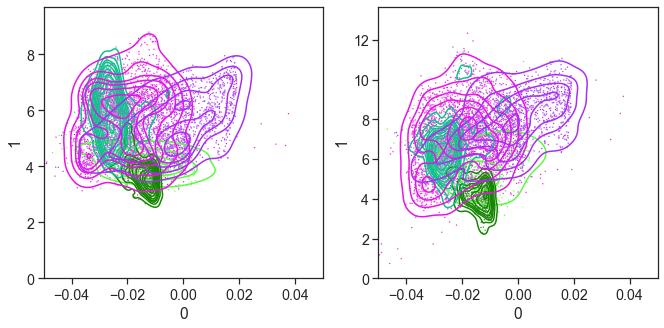

In [33]:
# morphotrack.distance.position2distance(warped_pos.sel(track=t).data)
g = 'plp1'

selections = ['track_01','track_02','track_03','track_v1','track_v2'] # 

fig, axs = plt.subplots(ncols=2, figsize=(11,5))
# sns.violinplot(data=df, x=3, y=1, ax=axs[0])
# axs[0].set_ylim(0)
for i, layer in enumerate(['layer3','layer4']):
    df = pd.concat([
        pd.Series(combined_local_flux[combined_local_flux.track_set.isin(selections)].data),
        pd.Series(layer_dens.sel(layer=layer,cell=g).data),
        pd.Series(layer_dens.sel(layer=layer,cell=g).track_set),
        pd.Series(layer_dens.sel(layer=layer,cell=g).track_set).isin(['track_v1','track_v2'])],
        axis=1)

    sns.kdeplot(data=df,x=0,y=1,hue=2,ax=axs[i],palette=color_dict, legend = False)
    sns.scatterplot(data=df,x=0,y=1,hue=2,ax=axs[i],s=2,palette=color_dict, legend = False)
    axs[i].set_xlim([-0.05,0.05]); axs[i].set_ylim(0)

    # calculate Cohen's d and median increase percentage
    pr = df[1][~df[3]]
    sv = df[1][df[3]]
    print(cohen_d(sv, pr))
    print((sv.median() - pr.median()) / pr.median())
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/plp1_layer34.svg')

In [39]:
selections = ['track_01','track_02','track_03','track_v1','track_v2']
layer = 'layer4'
x1 = combined_local_flux.track_set[combined_local_flux.track_set.isin(selections)].isin(['track_v1','track_v2']).data
x2 = combined_local_flux.data[combined_local_flux.track_set.isin(selections)]
y = layer_dens.sel(cell='slc17a7',layer=layer)
y = y.data[y.track_set.isin(selections)]
X = np.vstack([x1,x2]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
# reg = LinearRegression().fit(X, y)
print(cohen_f2(x1,x2,y))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     2696.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:57:27   Log-Likelihood:                -15862.
No. Observations:                5904   AIC:                         3.173e+04
Df Residuals:                    5901   BIC:                         3.175e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.0872      0.106    265.083      0.0

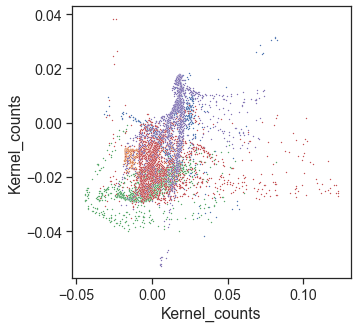

In [77]:
mean_lf4 = stack_local_flux.sel(time=slice(*layer_position['layer2'])).mean(dim='time')
mean_lf2 = stack_local_flux.sel(time=slice(*layer_position['layer4'])).mean(dim='time')

fig, axs = plt.subplots(figsize=(5,5))
for tr in selections:
    x = mean_lf4[mean_lf4.track_set==tr]
    y = mean_lf2[mean_lf2.track_set==tr]
    sns.scatterplot(x=x,y=y, ax=axs ,palette=color_dict[tr], s=2)
# axs.set_xlim([-0.1,0.1]); axs.set_ylim([-0.1,0.1])


## Layer thickness and flux regression

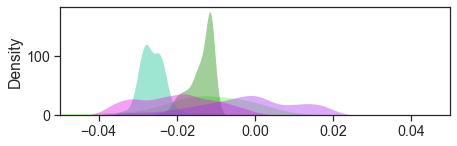

In [1080]:
fig, axs = plt.subplots(figsize=(7,2))
for tr in ['track_01','track_02','track_03','track_v1','track_v2']: # ,'track_v1','track_v2'
    sns.kdeplot(combined_local_flux.data[combined_local_flux.track_set.isin(tr)],color=color_dict[tr],fill=True,alpha=0.4,linewidth=0)
axs.set_xlim([-0.050,0.050])
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/local_flux_layer4.svg')

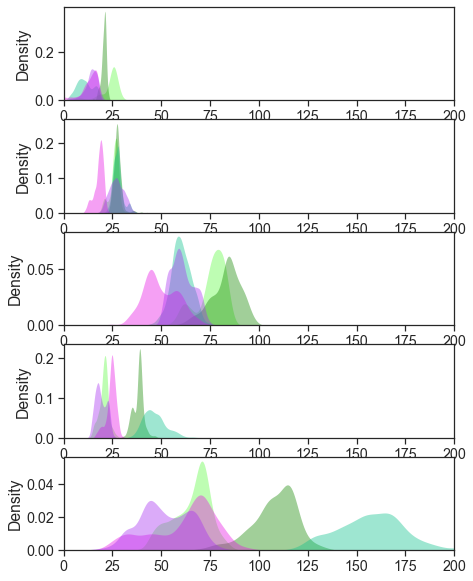

In [1083]:
selections = ['track_01','track_02','track_03','track_v1','track_v2']

fig, axs = plt.subplots(nrows=len(layers[:-1]),figsize=(7,2*len(layers[:-1])))
# layers
for i, layer in enumerate(layers[:-1]):
    th = layer_thickness.sel(cell='nuclei',layer=layer)
    for tr in selections:
        sns.kdeplot(th.data[th.track_set.isin(tr)],color=color_dict[tr],ax=axs[i],fill=True,alpha=0.4,linewidth=0)
    axs[i].set_xlim(0.0,200)
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/thickness_histgram.svg')

[0.47425703 0.30411068 0.10680797 0.06238217 0.04240738]


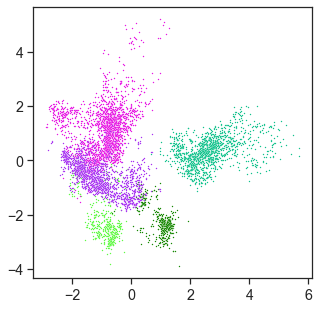

In [1090]:
selections = ['track_01','track_02','track_03','track_v1','track_v2']
fig, axs = plt.subplots(figsize=(5,5))
# trim_start = 0
# trim_end = 320
# thickness = stack_local_thickness[stack_local_thickness.track_set.isin(selections)].sel(time=slice(trim_start,trim_end)).fillna(0)
thickness = layer_thickness.sel(cell='nuclei')[layer_thickness.track_set.isin(selections)]
scaler = StandardScaler().fit(thickness)
thickness = scaler.transform(thickness)

pca = PCA().fit(thickness)
pcs = pca.transform(thickness)
pc1 = pcs[:,0]
pc2 = pcs[:,1]
for tr in selections:
    sel = layer_thickness.track_set.isin(tr)
    sns.scatterplot(x=pc1[sel],y=pc2[sel],color=color_dict[tr],s=2)
print(pca.explained_variance_ratio_[:5])
plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig6/thickness_pca.svg')

In [1088]:

selections = ['track_01','track_02','track_03','track_v1','track_v2']
layer = 'layer56'
x1 = combined_local_flux.track_set[combined_local_flux.track_set.isin(selections)].isin(['track_v1','track_v2']).data
x2 = combined_local_flux.data[combined_local_flux.track_set.isin(selections)]
y = layer_thickness.sel(cell='nuclei',layer=layer)
y = y.data[y.track_set.isin(selections)]
X = np.vstack([x1,x2]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
reg = LinearRegression().fit(X, y)
print(cohen_f2(x1,x2,y))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     5321.
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:15:48   Log-Likelihood:                -27812.
No. Observations:                5904   AIC:                         5.563e+04
Df Residuals:                    5901   BIC:                         5.565e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.5971      0.802    140.414      0.0

In [993]:
layer_thickness2 = xr.DataArray(np.nan,
                   coords={'track': tissue_sets['nuclei'].track,
                           'layer': layers,
                          },
                   dims=['track', 'layer']
                   ).astype(float)

g = 'nuclei'
for layer in layers:
    for tr in ['track_00','track_01','track_02','track_03','track_v1','track_v2']:
        ts = round(standard_shifts[tr][layer_position[layer][0]])
        te = round(standard_shifts[tr][layer_position[layer][1]])

        warped_pos = tracks[tr].Warped_position.rename({'warped_time':'time'})
        warped_pos = warped_pos.isel(time=slice(ts,te))

        for t in warped_pos.track.data:
            layer_thickness2.loc[dict(track=t,layer=layer)] = morphotrack.distance.position2distance(warped_pos.sel(track=t).data).sum()

layer_thickness2 = layer_thickness2.assign_coords({'track_set': tissue_sets['nuclei'].track_set})


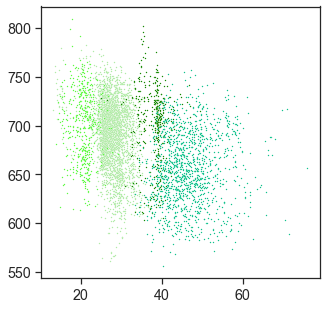

In [1064]:
layer = 'layer4'
g = 'nuclei'
selections = ['track_00','track_01','track_02','track_03']

trim_start = 0
trim_end = 320
thickness = layer_thickness2[layer_thickness2.track_set.isin(selections)].sel(layer=layer)

den = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)).fillna(0)
den = den[:,slice(*layer_position[layer])].mean(dim='time')

fig, axs = plt.subplots(figsize=(5,5))
for tr in selections:
    sel = den.track_set.isin(tr)
    sns.scatterplot(x=thickness.data[sel], y=den.data[sel],s=2, color=color_dict[tr])


In [ ]:
# # thickness = stack_local_thickness[stack_local_thickness.track_set.isin(selections)].sel(time=slice(trim_start,trim_end)).fillna(0)
# scaler1 = StandardScaler().fit(thickness)
# thickness = scaler1.transform(thickness)

# den = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)).fillna(0)
# scaler2 = StandardScaler().fit(den)
# den = scaler2.transform(den)

# pls = PLSRegression(n_components=15).fit(thickness, den)
# X_transform, Y_transform = pls.transform(X=thickness,Y=den)

# i = 0
# fig, axs = plt.subplots(figsize=(5,5))
# for tr in selections:
#     sel = stack_local_thickness[stack_local_thickness.track_set.isin(selections)].track_set.isin(tr)
#     sns.scatterplot(x=X_transform[:,i][sel],y=Y_transform[:,i][sel],s=2,color=color_dict[tr])

# selections = ['track_02']
# thickness = layer_thickness2[layer_thickness2.track_set.isin(selections)]
# # thickness = stack_local_thickness[stack_local_thickness.track_set.isin(selections)].sel(time=slice(trim_start,trim_end)).fillna(0)
# thickness = scaler1.transform(thickness)
# den = tissue_sets[g][tissue_sets[g].track_set.isin(selections)].sel(time=slice(trim_start,trim_end)).fillna(0)
# den = scaler2.transform(den)
# X_transform, Y_transform = pls.transform(X=thickness,Y=den)
# sns.scatterplot(x=X_transform[:,i],y=Y_transform[:,i],s=2,color='red')

In [258]:
tr = 'track_02'
#tracks[tr]
a = (combined_flux>-2) & (combined_flux<2)
b = tracks[tr].sel(track=a.track[(a.track_set == tr) & a])
c = morphotrack.image.visualize_in_original_space(b.Position,b.Distance)
viewer = napari.Viewer()
#viewer.add_image(c, colormap='red',blending='additive')
viewer.add_image(image_set[tr]['nuclei'], name='nuclei', colormap='gray', blending='additive')
viewer.add_image(image_set[tr]['vessel'], name='vessel', colormap='gray', blending='additive')

<Image layer 'vessel' at 0x7efa372be5b0>

## thickness analysis to confirm consistency with the past report

In [370]:
### How about layer thickness??
layer_thickness2 = xr.DataArray(np.nan,
                   coords={'track': tissue_sets['nuclei'].track,
                           'layer': layers
                          },
                   dims=['track', 'layer']
                   ).astype(float)

for tr in tracks:
    for layer in layers:
        layer_reference_time = layer_position[layer]

        ts = round(standard_shifts[tr][layer_reference_time[0]])
        te = round(standard_shifts[tr][layer_reference_time[1]])

        warped_pos = tracks[tr].Warped_position.rename({'warped_time':'time'})
        warped_pos = warped_pos.isel(time=slice(ts,te))

        for t in warped_pos.track.data:
            layer_thickness2.loc[dict(track=t,layer=layer)] = morphotrack.distance.position2distance(warped_pos.sel(track=t).data).sum()

layer_thickness2 = layer_thickness2.assign_coords({'track_set': ('track',tissue_sets['nuclei'].track_set.data)})

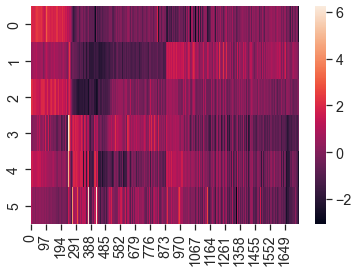

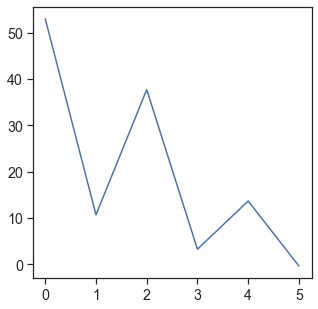

In [466]:
sel = (combined_flux>=-2.) & (combined_flux<=2.)

a = layer_thickness.sel(cell='nuclei').data[layer_thickness.track_set.isin(['track_01','track_02'])&sel,:]
b = layer_thickness.sel(cell='nuclei').data[layer_thickness.track_set.isin(['track_v1','track_v2'])&sel,:]
c = layer_thickness.sel(cell='nuclei').data[layer_thickness.track_set.isin(['track_00'])&sel,:]
sns.heatmap(zscore(np.vstack([a,b]),axis=0).T)
# track_counter
fig, axs = plt.subplots(ncols=1, figsize=(5,5))
axs.plot(ttest_ind(a,b).statistic)
axs.plot(ttest_ind(a,c).statistic)

## cell size analysis

In [344]:
# read cellular coordinate
scaling_factor = np.asarray([3,0.65,0.65])
cell_size = {}
for key in cell_coords_original:
    temp_dict = {}
    for i in cell_coords_original[key]:
        df = cell_coords_original[key][i]
        z = (df['bbox-3']-df['bbox-0']) * scaling_factor[0] / 10 # convert unit to 10 um for consistency
        y = (df['bbox-4']-df['bbox-1']) * scaling_factor[1] / 10
        x = (df['bbox-5']-df['bbox-2']) * scaling_factor[2] / 10
        area = (x*y).rename('p_area')
        vol = (x*y*z).rename('bbox_vol')
        temp_dict[i] = pd.concat([area,vol],axis=1)
    cell_size[key] = temp_dict

In [368]:
viewer = napari.Viewer()
tr = 'track_v2'
g = 'slc17a7'
color_vis = morphotrack.image.vector_color_mapping(np.sqrt(cell_size[tr][g]['p_area']),colormap='plasma',low_p=5, high_p=95)

viewer.add_points(
    cell_coords[tr][g],
    size = np.sqrt(cell_size[tr][g]['p_area']),
    face_color = color_vis,
    edge_width=0,
)


/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Points' at 0x7fc8405b3c70>

In [151]:
viewer = napari.Viewer()
viewer.add_image(kernel_counts['slc17a7'],colormap='magenta',blending='additive')
viewer.add_image(kernel_counts['plp1'],colormap='cyan',blending='additive')
viewer.add_image(tracks[tr].Total_warped.sel(displacement='t2s'),colormap='green',blending='additive')
viewer.add_image(kernel_counts['slc17a7'] / tracks[tr].Total_warped.sel(displacement='t2s'),contrast_limits=[0,1],colormap='turbo',blending='additive', visible=False)
viewer.add_image(kernel_counts['plp1'] / tracks[tr].Total_warped.sel(displacement='t2s'),contrast_limits=[0,1],colormap='turbo',blending='additive', visible=False)

<Image layer 'Image [4]' at 0x7fce14d4d4c0>

In [146]:
# visualization in original space
g = 'slc17a7'
img = morphotrack.image.visualize_in_original_space(tracks[tr].Position, kernel_counts[g] / tracks[tr].Total_warped.sel(displacement='t2s'), image_set[tr]['nuclei'].shape)

viewer = napari.Viewer()
viewer.add_image(img,colormap='turbo',blending='additive')
viewer.add_image(image_set[tr][g],colormap='gray',blending='additive')
viewer.add_points(
    cell_coords[tr][g],
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc'
)
# label = viewer.add_labels(np.zeros(img.shape).astype(int))

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Points' at 0x7fce16a0f220>

(0.0, 493.8)

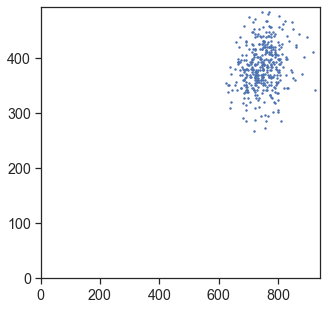

In [131]:
# get scatter plot of nucleic density and slc17a7
# those two should be very similar
reference_time = 140

n_dens = tracks[tr].Total_warped.sel(displacement='t2s',time=reference_time)
g_dens = kernel_counts[g].sel(time=reference_time)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.scatter(n_dens,g_dens,s=2)
ax.set_xlim(0);ax.set_ylim(0)

In [152]:
# io.imsave('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/lcmask.tif',label.data.astype(np.int8))

In [76]:
reference_time = 170 # time corresponding to layer IV is a good choice.
ref_time_in_standard = track_ds.Total_arg.sel(displacement='t2s').sel(time=reference_time)
layer_position = []
for ti, tr in zip(ref_time_in_standard.data,ref_time_in_standard.track.data):
    layer_position.append(track_ds.Position.sel(track=tr).interp(time=ti))
layer_position = xr.concat(layer_position,dim='track')

clf = pickle.load(open(os.path.join(io_directory,'model.pkl'), 'rb'))
norm_flow_on_coordinate = morphotrack.points.model_to_get_flow_func(clf.degree, clf)
local_flux = morphotrack.points.get_local_flux(layer_position.data, norm_flow_on_coordinate, radius)

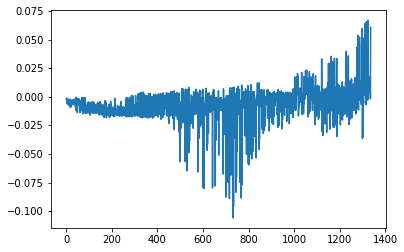

In [80]:
plt.plot(local_flux)

In [485]:
viewer = napari.Viewer()
z_s = 100; z_e = 200
viewer.add_image(image_set['track_01']['nuclei'][z_s:z_e,:,:],blending='additive')
viewer.add_image(image_set['track_01']['vessel'][z_s:z_e,:,:],blending='additive')
viewer.add_image(image_set['track_01']['slc17a7'][z_s:z_e,:,:],blending='additive')
viewer.add_image(image_set['track_01']['plp1'][z_s:z_e,:,:],blending='additive')

my_mask = image_set['track_01']['nuclei'][z_s:z_e,:,:]>300
p = cell_coords['track_01']['plp1'].copy()
p[:,0] = p[:,0]-z_s
p = p[p[:,0]>=0,:]
p = p[p[:,0]<z_e-z_s,:]
p = p[my_mask[tuple(p.astype(int).T)],:]
viewer.add_points(p[::20],size=2, face_color = '#cfd602',edge_width=0)

p = cell_coords['track_01']['slc17a7'].copy()
p[:,0] = p[:,0]-z_s
p = p[p[:,0]>=0,:]
p = p[p[:,0]<z_e-z_s,:]
p = p[my_mask[tuple(p.astype(int).T)],:]
viewer.add_points(p[::100],size=2, face_color = '#0ec220',edge_width=0)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Points [1]' at 0x7f495b0de610>